In [1]:
## Audio2Art: Transforming Voice Prompts into Visual Creations using Transformers

## This project converts voice prompts into images using transformer models.
# Created by Ayush Prajapati, Rutu Bhatt, Dipen Trivedi

In [2]:
## Before running the first cell:
## Go to Runtime → Change runtime type Set Hardware accelerator to T4 GPU (Recommended for Stable Diffusion speed and compatibility).

## Step 1: Install Required Libraries

## First, let's install the necessary packages:


In [3]:
# Install Python libraries
%pip install streamlit diffusers accelerate transformers librosa torch soundfile

# For speech-to-text with Wav2Vec
%pip install datasets jiwer

# Install Node.js and localtunnel
!apt-get update
!apt-get install -y nodejs npm
!npm install -g localtunnel

print("All required libraries installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
## Step 2: Create and Initialize the Models

## In this step, we'll create our ImageModel class that handles both speech-to-text and text-to-image conversion.


In [5]:
%%writefile ImageModel.py

import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from diffusers import StableDiffusionPipeline
import soundfile as sf
import librosa as lb
import numpy as np
import time
from typing import Literal, Tuple
from PIL import Image

def promptgen(file):
    """
    Process an audio file and generate a transcription of its content.

    Parameters:
    file (str): Path to the audio file

    Returns:
    str: Transcribed text from the audio file
    """
    try:
        tokenizer = Wav2Vec2Tokenizer.from_pretrained('facebook/wav2vec2-base-960h')
        model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-960h')

        print(f"Loading audio file: {file}")
        # Try to load the audio file with error handling
        try:
            waveform, rate = lb.load(file, sr=16000, mono=True)
        except Exception as e:
            print(f"Error loading audio with librosa: {e}")
            # Try alternative loading with soundfile directly
            import soundfile as sf
            audio_data, rate = sf.read(file)
            if len(audio_data.shape) > 1:  # Convert stereo to mono if needed
                audio_data = audio_data.mean(axis=1)
            waveform = lb.resample(audio_data, orig_sr=rate, target_sr=16000)

        # Normalize the waveform
        waveform = waveform / (np.max(np.abs(waveform)) + 1e-10)

        # Process with Wav2Vec
        input_values = tokenizer(waveform, return_tensors='pt').input_values
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)

        transcription = tokenizer.batch_decode(predicted_ids)

        # If transcription is empty or just whitespace, return a default message
        if not transcription[0].strip():
            return "a beautiful abstract painting with vibrant colors"

        return transcription[0]
    except Exception as e:
        print(f"Error in promptgen: {e}")
        # Return a default prompt in case of any error
        return "a beautiful abstract painting with vibrant colors"

def text2image(prompt: str, repo_id: Literal["runwayml/stable-diffusion-v1-5",
                                            "CompVis/stable-diffusion-v1-4",
                                            "stabilityai/stable-diffusion-2-1"]) -> Tuple[Image.Image, float, float]:
    """
    Generate an image from a text prompt using Stable Diffusion models.

    Parameters:
    prompt (str): Text description to generate the image from
    repo_id (Literal): Repository ID of the Stable Diffusion model to use

    Returns:
    tuple: (generated image, start time, end time)
    """
    # Set seed for reproducibility
    seed = 2024
    generator = torch.manual_seed(seed)

    # Set constants for the image generation process
    NUM_ITERS_TO_RUN = 1
    NUM_INFERENCE_STEPS = 50
    NUM_IMAGES_PER_PROMPT = 1

    # Record start time
    start = time.time()

    # Initialize the pipeline based on GPU availability
    if torch.cuda.is_available():
        pipe = StableDiffusionPipeline.from_pretrained(
            repo_id,
            torch_dtype=torch.float16,
            generator=generator
        )
        pipe = pipe.to("cuda")
    else:
        pipe = StableDiffusionPipeline.from_pretrained(
            repo_id,
            torch_dtype=torch.float32,
            generator=generator
        )

    # Generate images
    images = []
    for _ in range(NUM_ITERS_TO_RUN):
        result = pipe(
            prompt=prompt,
            num_inference_steps=NUM_INFERENCE_STEPS,
            num_images_per_prompt=NUM_IMAGES_PER_PROMPT,
            generator=generator
        )
        images.extend(result.images)

    # Record end time
    end = time.time()

    # Return the first generated image and timing information
    return images[0], start, end


class ImageModel:
    def __init__(self):
        """
        Initialize the speech-to-text and text-to-image models
        """
        # Check if GPU is available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        # Initialize Speech-to-Text model (Wav2Vec2)
        self.speech_model_name = "facebook/wav2vec2-base-960h"
        self.speech_tokenizer = None
        self.speech_model = None

        # Initialize Text-to-Image model (Stable Diffusion)
        self.image_model_name = "runwayml/stable-diffusion-v1-5"
        self.image_generator = None

        # Load models
        self.load_speech_model()
        self.load_image_model()

    def load_speech_model(self):
        """
        Load the speech-to-text model (Wav2Vec2)
        """
        print("Loading speech-to-text model...")
        try:
            self.speech_tokenizer = Wav2Vec2Tokenizer.from_pretrained(self.speech_model_name)
            self.speech_model = Wav2Vec2ForCTC.from_pretrained(self.speech_model_name).to(self.device)
            print("Speech-to-text model loaded successfully.")
        except Exception as e:
            print(f"Error loading speech-to-text model: {e}")

    def load_image_model(self):
        """
        Load the text-to-image model (Stable Diffusion)
        """
        print("Loading text-to-image model...")
        try:
            self.image_generator = StableDiffusionPipeline.from_pretrained(
                self.image_model_name,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32
            )
            self.image_generator = self.image_generator.to(self.device)
            print("Text-to-image model loaded successfully.")
        except Exception as e:
            print(f"Error loading text-to-image model: {e}")

    def speech_to_text(self, audio_file_path):
        """
        Convert speech to text using Wav2Vec2 model

        Parameters:
        audio_file_path (str): Path to the audio file

        Returns:
        str: Transcribed text
        """
        try:
            # Load audio file
            audio, sample_rate = sf.read(audio_file_path)

            # Resample if necessary
            if sample_rate != 16000:
                audio = lb.resample(audio, orig_sr=sample_rate, target_sr=16000)
                sample_rate = 16000

            # Convert to mono if stereo
            if len(audio.shape) > 1:
                audio = audio.mean(axis=1)

            # Normalize audio
            audio = audio / np.max(np.abs(audio))

            # Process audio with Wav2Vec2
            input_values = self.speech_tokenizer(
                audio,
                return_tensors="pt",
                padding=True
            ).input_values.to(self.device)

            # Generate transcription
            with torch.no_grad():
                logits = self.speech_model(input_values).logits

            # Decode the prediction
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = self.speech_tokenizer.batch_decode(predicted_ids)[0]

            print(f"Transcription: {transcription}")
            return transcription

        except Exception as e:
            print(f"Error in speech-to-text conversion: {e}")
            return ""

    def text_to_image(self, prompt, output_path="generated_image.png"):
        """
        Generate an image from text using Stable Diffusion

        Parameters:
        prompt (str): Text prompt for image generation
        output_path (str): Path to save the generated image

        Returns:
        image: Generated image
        """
        try:
            print(f"Generating image from prompt: {prompt}")

            # Generate image from prompt
            with torch.autocast(self.device):
                image = self.image_generator(prompt).images[0]

            # Save the image
            image.save(output_path)
            print(f"Image saved to {output_path}")
            return image

        except Exception as e:
            print(f"Error in text-to-image conversion: {e}")
            return None

    def audio_to_image(self, audio_file_path, output_path="generated_image.png"):
        """
        Convert audio to image (speech-to-text followed by text-to-image)

        Parameters:
        audio_file_path (str): Path to the audio file
        output_path (str): Path to save the generated image

        Returns:
        tuple: (transcription, image)
        """
        # First convert speech to text
        transcription = self.speech_to_text(audio_file_path)

        if not transcription:
            print("No transcription generated.")
            return None, None

        # Then convert text to image
        image = self.text_to_image(transcription, output_path)

        return transcription, image

# For testing
if __name__ == "__main__":
    model = ImageModel()
    print("Models initialized successfully!")


Writing ImageModel.py


In [6]:
## Step 3: Test the ImageModel

## Let's create an instance of our model and test the text-to-image functionality:


Using device: cuda
Loading speech-to-text model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Speech-to-text model loaded successfully.
Loading text-to-image model...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Text-to-image model loaded successfully.
Generating image from prompt: A beautiful sunset over mountains with reflections in a lake


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to test_generated_image.png


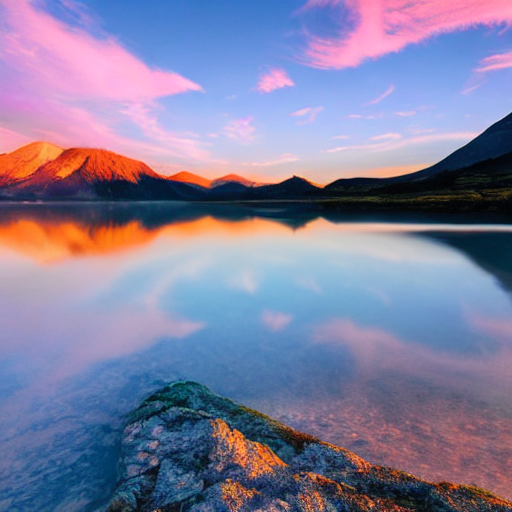

In [7]:
# Test the ImageModel
from ImageModel import ImageModel

# Create instance of the model
model = ImageModel()

# Define input type with Literal for demonstration
from typing import Literal
OutputFormat = Literal["png", "jpg"]
output_format: OutputFormat = "png"

# If we have a test audio file, we could test the full pipeline
# Otherwise, we can test the text-to-image part
test_prompt = "A beautiful sunset over mountains with reflections in a lake"
output_path = f"test_generated_image.{output_format}"

# Test text-to-image generation
image = model.text_to_image(test_prompt, output_path)

# Display the generated image
from IPython.display import Image, display
display(Image(output_path))


In [8]:
## Step 4: Test the promptgen Function

## Now let's test the speech-to-text functionality using the `promptgen` function:


In [9]:
# Create a sample directory for audio files
!mkdir -p sample_data

# For testing the promptgen function, we need a sample audio file
# In a real scenario, we would use a real audio file
# Here, let's try to find if we have any audio file or create a simple one

# Option 1: Check if there's a sample audio file in the sample_data directory
import os
if not any(f.endswith('.wav') for f in os.listdir('sample_data')):
    # Option 2: Generate a simple sine wave audio file for testing
    import numpy as np
    import soundfile as sf

    print("Creating a sample audio file...")
    # Create a simple sine wave
    sample_rate = 16000
    duration = 2  # seconds
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = np.sin(2 * np.pi * 440 * t)  # 440 Hz sine wave

    # Save as wav file
    sf.write('sample_data/test_audio.wav', audio, sample_rate)
    print("Sample audio file created at sample_data/test_audio.wav")

# Test the promptgen function with the sample audio file
from ImageModel import promptgen

try:
    transcription = promptgen('sample_data/test_audio.wav')
    print(f"Transcription: {transcription}")
except Exception as e:
    print(f"Error testing promptgen function: {e}")
    print("Note: In a real scenario, you would need an actual speech audio file for meaningful transcription.")


Creating a sample audio file...
Sample audio file created at sample_data/test_audio.wav


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading audio file: sample_data/test_audio.wav
Transcription: a beautiful abstract painting with vibrant colors


In [10]:
## Step 5: Test the text2image Function

## Let's test the `text2image` function separately:


Keyword arguments {'generator': <torch._C.Generator object at 0x7a932b3f89d0>} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image generation took 40.90 seconds


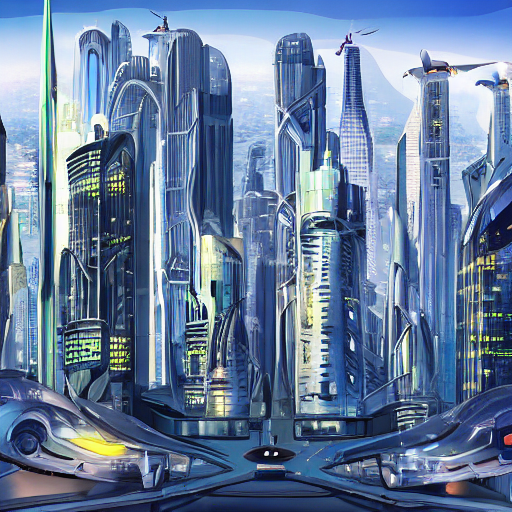

In [11]:
# Test the text2image function
from ImageModel import text2image

test_prompt = "A futuristic city with flying cars and tall skyscrapers"
repo_id = "runwayml/stable-diffusion-v1-5"  # Using v1-5 for better quality

try:
    # Generate the image and get timing information
    generated_image, start_time, end_time = text2image(test_prompt, repo_id)

    # Save the generated image
    output_path = "generated_city.png"
    generated_image.save(output_path)

    # Display the generated image and timing info
    from IPython.display import Image, display
    print(f"Image generation took {end_time - start_time:.2f} seconds")
    display(Image(output_path))
except Exception as e:
    print(f"Error in text2image function: {e}")
    print("Note: This function requires significant computational resources.")


In [12]:
## Step 6: Create the Streamlit Web Application

## Now let's create our Streamlit application with a user-friendly interface:

In [13]:
%%writefile app.py
import streamlit as st
from ImageModel import promptgen, text2image
from io import BytesIO
import os
import time
from typing import Literal
from PIL import Image
import tempfile

def app():
    # Set the title of the web page
    st.title("Audio2Art: Transforming Audio Prompts into Visual Creations")

    # Create a file uploader for wav files
    upload_file = st.file_uploader("Choose your .wav audio file", type=["wav"])

    # Dropdown for selecting the model option
    option = st.selectbox(
        'Select Model',
        ("runwayml/stable-diffusion-v1-5", "CompVis/stable-diffusion-v1-4", "stabilityai/stable-diffusion-2-1")
    )

    # Create session state to store results
    if 'generated_image' not in st.session_state:
        st.session_state.generated_image = None
        st.session_state.image_buffer = None

    # Create a form with a submit button
    with st.form("my_form"):
        submit = st.form_submit_button(label="Submit Audio File!")

    # Process when submit is pressed (outside the form)
    if submit:
        if upload_file is not None:
            # Show a spinner while processing
            with st.spinner("Generating Image ... It may take some time."):
                try:
                    # Save uploaded file to a temporary file
                    with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp_file:
                        tmp_file.write(upload_file.getvalue())
                        tmp_path = tmp_file.name

                    # Generate prompt from audio using the file path
                    prompt = promptgen(tmp_path)
                    st.write(f"Generated prompt: {prompt}")

                    # Clean up the temporary file
                    os.unlink(tmp_path)

                    # Generate image from prompt
                    im, start, end = text2image(prompt, option)

                    # Create a buffer for the image and store in session state
                    buf = BytesIO()
                    im.save(buf, format="PNG")
                    st.session_state.generated_image = im
                    st.session_state.image_buffer = buf

                    # Calculate processing time
                    processing_time = end - start

                    # Display success message with processing time
                    st.success(f"Image generated in {processing_time:.2f} seconds!")

                    # Display the generated image
                    st.image(im)

                except Exception as e:
                    st.error(f"Error processing audio: {str(e)}")
        else:
            st.error("Please upload an audio file!")

    # Download button outside the form
    if st.session_state.generated_image is not None:
        st.download_button(
            label="Download Image",
            data=st.session_state.image_buffer.getvalue(),
            file_name="generated_image.png",
            mime="image/png"
        )

    # Add sidebar with guide and examples
    with st.sidebar:
        st.header("How to use Audio2Art")
        st.write("""
        1. Upload a .wav audio file containing your voice prompt
        2. Select the model you want to use
        3. Click 'Submit Audio File!'
        4. Wait for the image to be generated
        5. Download the generated image if desired
        """)

        st.header("Examples")
        st.write("""
        Try these voice prompts:
        - "A beautiful sunset over mountains with reflections in a lake"
        - "A futuristic city with flying cars and tall skyscrapers"
        - "A cute puppy playing in a garden full of flowers"
        """)

# Run the app when the script is executed directly
if __name__ == "__main__":
    app()


Writing app.py


In [14]:
## Step 7: Set Up the Deployment Environment

## Let's create a deployment directory structure:


In [15]:
# Create directories for our deployment
!mkdir -p deployment/sample_data

# Copy our key files to the deployment directory
!cp ImageModel.py deployment/
!cp app.py deployment/

# Create directories for uploads and generated images
!mkdir -p deployment/uploads
!mkdir -p deployment/generated_images

# List the deployment directory structure
!ls -la deployment/

total 40
drwxr-xr-x 5 root root 4096 Aug  8 16:07 .
drwxr-xr-x 1 root root 4096 Aug  8 16:07 ..
-rw-r--r-- 1 root root 3730 Aug  8 16:07 app.py
drwxr-xr-x 2 root root 4096 Aug  8 16:07 generated_images
-rw-r--r-- 1 root root 8813 Aug  8 16:07 ImageModel.py
drwxr-xr-x 2 root root 4096 Aug  8 16:07 sample_data
drwxr-xr-x 2 root root 4096 Aug  8 16:07 uploads


In [16]:
## Step 8: Deploy the Application

## We have deployment option: Localtunnel. Let's implement.

In [ ]:
# Install Node.js and npm if not already installed
!apt-get update -qq
!apt-get install -y nodejs npm

# Install localtunnel globally
!npm install -g localtunnel

# Navigate to the deployment directory
%cd deployment

# Launch the Streamlit app
!streamlit run app.py &>/dev/null &

# Wait a few seconds for Streamlit to start
import time
time.sleep(5)

# Create a tunnel using localtunnel
!lt --port 8501

print("\n🚀 Your Audio2Art app is now deployed with localtunnel!")
print("Copy and open the URL shown above to access your application.")
print("\nNote: This URL will only be active while this notebook is running.")
print("When you're done, run the stop cell below to stop the app.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
npm is already the newest version (8.5.1~ds-1).
nodejs is already the newest version (12.22.9~dfsg-1ubuntu3.6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

changed 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 high severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
/content/deployment
your url is: https://calm-wombats-divide.loca.lt


In [ ]:
# Stop the Streamlit app deployed with localtunnel. Remove the comment for stop.
## !pkill -f streamlit
